In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.mixed_precision import set_global_policy

# Rice Disease Classification with Memory-Efficient Training

This notebook trains a CNN model to classify rice plant diseases while optimizing for memory usage. Key optimizations:
1. Mixed precision training (float16/float32)
2. Smaller batch size (8 instead of 16/32)
3. Memory-efficient model architecture
4. Checkpointing to save progress if kernel dies

In [2]:
# Configure GPU memory growth to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Physical GPUs: {len(gpus)}, Logical GPUs: {len(logical_gpus)}")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Physical GPUs: 2, Logical GPUs: 2


In [3]:
# Enable mixed precision training to cut memory usage in half
set_global_policy('mixed_float16')  # Use float16 for most calculations but float32 where needed
print("Mixed precision policy set to: mixed_float16")

Your GPUs may run slowly with dtype policy mixed_float16 because they do not have compute capability of at least 7.0. Your GPUs:
  DML, no compute capability (probably not an Nvidia GPU) (x2)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Mixed precision policy set to: mixed_float16


In [4]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU devices:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.10.0
Num GPUs Available: 2
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [5]:
IMAGE_SIZE = (224, 224)  # Reduced image size to prevent memory issues
BATCH_SIZE = 8  # Further reduced batch size to prevent memory issues
CHANNELS = 3
EPOCHS = 25  # Reduced to make completion more likely with current setup

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "datasetMendely",
    shuffle=True,
    image_size = (IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 4767 files belonging to 4 classes.


In [7]:
class_names = dataset.class_names
class_names

['Bacterialblight', 'Blast', 'Brownspot', 'HealthyRiceLeaf']

In [8]:
len(dataset)

596

In [9]:
216*32

6912

In [10]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(8, 224, 224, 3)
[1 1 1 1 1 0 0 2]


Displaying 8 images from a batch of 8


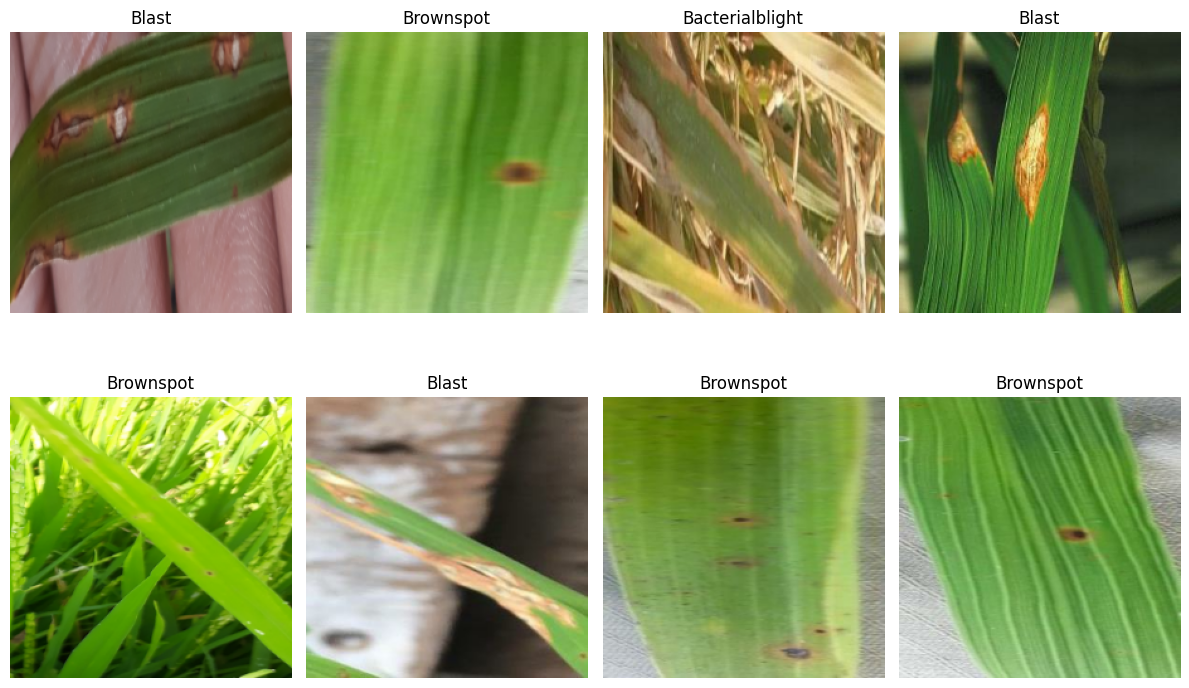

In [11]:
plt.figure(figsize=(12,8))
for image_batch, label_batch in dataset.take(1):
    # Get the actual batch size (could be smaller than BATCH_SIZE)
    batch_size = image_batch.shape[0]
    grid_size = min(12, batch_size)  # Display at most 12 images
    
    # Calculate grid dimensions
    cols = min(4, grid_size)  # At most 4 columns
    rows = int(np.ceil(grid_size / cols))  # Calculate needed rows
    
    # Display each image
    for i in range(grid_size):
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
    
    plt.tight_layout()
    print(f"Displaying {grid_size} images from a batch of {batch_size}")

In [12]:
train_size = 0.8
test_size = 0.2

In [13]:
len(dataset)*train_size

476.8

In [14]:
val_size = 0.1
len(dataset)*val_size

59.6

In [15]:
train_ds = dataset.take(142)
test_ds = dataset.skip(142)

In [16]:
val_ds = test_ds.take(17)
test_ds = test_ds.skip(17)
len(train_ds), len(test_ds), len(val_ds)

(142, 437, 17)

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split = 0.1, shuffle=True, shuffle_size = 10000):

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds), len(test_ds), len(val_ds)

(476, 61, 59)

In [20]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

tf.keras.backend.clear_session()

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),  # height, width
    layers.Rescaling(1.0 / 255)
])

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])

In [23]:
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)  # (height, width, channels)
n_classes = 6  # Based on your dataset folders

# Simpler model architecture to reduce memory usage
model = models.Sequential([
    resize_and_rescale,
    # Data augmentation only during training
    tf.keras.layers.Lambda(lambda x: data_augmentation(x, training=True)),
    
    # Efficient model architecture
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# More efficient model build
model.build(input_shape=(None,) + input_shape)  # None for batch dimension


In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
# Clear any lingering memory before training
import gc
gc.collect()
tf.keras.backend.clear_session()

In [27]:
# Define callbacks for better training with checkpointing to save progress
import os

# Create checkpoint directory if it doesn't exist
checkpoint_dir = "./model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

callbacks = [
    # Save model after each epoch
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, "model_{epoch:02d}_{val_accuracy:.4f}.h5"),
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    ),
    # Early stopping to prevent overfitting
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    # Reduce learning rate when training plateaus
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.0001
    )
]

In [28]:
import psutil

class MemoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        memory = psutil.virtual_memory()
        print(f"Epoch {epoch+1}: System RAM used: {memory.used / (1024**3):.2f} GB ({memory.percent}%)")
        if gpus:
            gpu_details = tf.config.experimental.get_memory_info('GPU:0')
            print(f"Epoch {epoch+1}: GPU Memory used: {gpu_details['current'] / (1024**3):.2f} GB")

callbacks.append(MemoryCallback())

In [29]:
# Monitor memory usage
import psutil
import os

def print_memory_usage():
    # System RAM
    memory = psutil.virtual_memory()
    print(f"System RAM: {memory.used / (1024**3):.1f}GB / {memory.total / (1024**3):.1f}GB ({memory.percent:.1f}%)")
    
    # GPU memory
    if gpus:
        gpu_details = tf.config.experimental.get_memory_info('GPU:0')
        print(f"GPU Memory: {gpu_details['current'] / (1024**3):.1f}GB / {gpu_details['peak'] / (1024**3):.1f}GB peak")

print_memory_usage()

System RAM: 11.0GB / 23.7GB (46.4%)
GPU Memory: 0.0GB / 0.1GB peak


In [30]:
 history = model.fit(
    train_ds,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/25
476/476 [==============================] - ETA: 0s - loss: 0.8156 - accuracy: 0.6743WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.

Epoch 1: val_accuracy improved from -inf to 0.77542, saving model to ./model_checkpoints\model_01_0.7754.h5
Epoch 1: System RAM used: 11.62 GB (49.0%)
Epoch 1: GPU Memory used: 0.05 GB
476/476 [==============================] - 40s 66ms/step - loss: 0.8156 - accuracy: 0.6743 - val_loss: 0.5445 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 2/25
476/476 [==============================] - ETA: 0s - loss: 0.5324 - accuracy: 0.7915
Epoch 2: val_accuracy improved from 0.77542 to 0.85169, saving model to ./model_checkpoints\model_02_0.8517.h5
Epoch 2: System RAM used: 11.63 GB (49.1%)
Epoch 2: GPU Memory used: 0.05 GB
476/476 [==============================] - 33s 68ms/step - loss: 0.5324 - accuracy: 0.7915 - val_loss: 0.3700 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 3/25
476/476 [===

In [31]:
# Code to resume training if the kernel dies
# Just run this cell to reload from the most recent checkpoint
import os
import glob

def resume_training():
    # Find the latest checkpoint
    checkpoints = glob.glob(os.path.join(checkpoint_dir, "*.h5"))
    
    if not checkpoints:
        print("No checkpoints found to resume from!")
        return
    
    # Get the most recent checkpoint (by epoch)
    latest_checkpoint = max(checkpoints, key=os.path.getmtime)
    print(f"Resuming from checkpoint: {latest_checkpoint}")
    
    # Load the model
    resumed_model = tf.keras.models.load_model(latest_checkpoint)
    
    # Get the epoch number from the filename
    epoch_str = os.path.basename(latest_checkpoint).split('_')[1]
    starting_epoch = int(epoch_str)
    
    print(f"Resuming training from epoch {starting_epoch + 1}")
    
    # Continue training
    history = resumed_model.fit(
        train_ds,
        epochs=EPOCHS,
        initial_epoch=starting_epoch,
        verbose=1,
        validation_data=val_ds,
        callbacks=callbacks
    )
    
    # Save final model
    print("Resumed model saved as 'rice_disease_model_resumed.h5'")
    resumed_model.save("rice_disease_model_resumed.h5")
    return history, resumed_model

# To resume training after kernel dies, just run this cell
# history, resumed_model = resume_training()model.save("my_model", save_format="tf")


Resuming from checkpoint: ./model_checkpoints\model_20_1.0000.h5
Resuming training from epoch 21
Epoch 21/25
476/476 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9926WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.

Epoch 21: val_accuracy did not improve from 1.00000
Epoch 21: System RAM used: 11.32 GB (47.7%)
Epoch 21: GPU Memory used: 0.14 GB
476/476 [==============================] - 37s 73ms/step - loss: 0.0317 - accuracy: 0.9926 - val_loss: 0.1209 - val_accuracy: 0.9640 - lr: 2.0000e-04
Epoch 22/25
476/476 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9932
Epoch 22: val_accuracy did not improve from 1.00000
Epoch 22: System RAM used: 11.25 GB (47.4%)
Epoch 22: GPU Memory used: 0.14 GB
476/476 [==============================] - 31s 63ms/step - loss: 0.0230 - accuracy: 0.9932 - val_loss: 0.0333 - val_accuracy: 0.9894 - lr: 2.0000e-04
Epoch 23/25
476/476 [======

In [48]:
resumed_model.save("1", save_format="tf")

AssertionError: Tried to export a function which references an 'untracked' resource. TensorFlow objects (e.g. tf.Variable) captured by functions must be 'tracked' by assigning them to an attribute of a tracked object or assigned to an attribute of the main object directly. See the information below:
	Function name = b'__inference_signature_wrapper_169164'
	Captured Tensor = <ResourceHandle(name="Resource-12-at-0x123dc95d070", device="/job:localhost/replica:0/task:0/device:GPU:0", container="Anonymous", type="class tensorflow::Var", dtype and shapes : "[ DType enum: 9, Shape: [3] ]")>
	Trackable referencing this tensor = <tf.Variable 'random_rotation/StateVar:0' shape=(3,) dtype=int64>
	Internal Tensor = Tensor("169140:0", shape=(), dtype=resource)

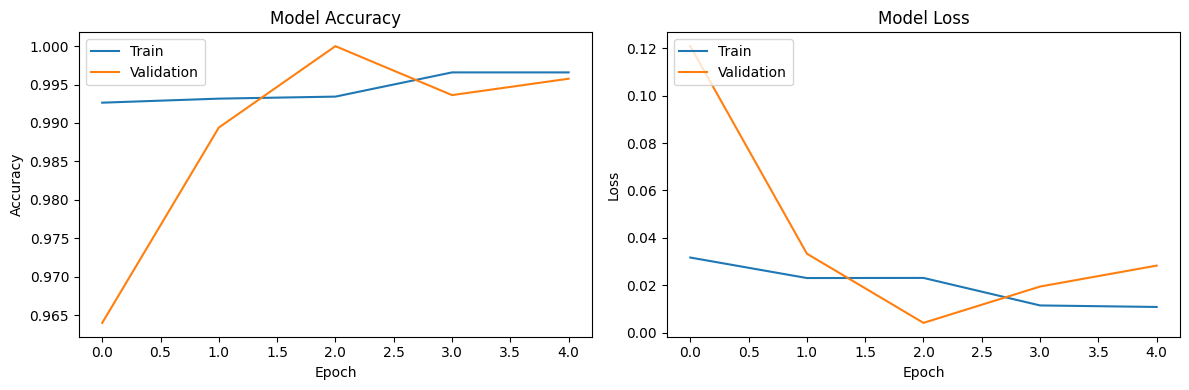

In [32]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [33]:
# Evaluate the model on test data
test_results = resumed_model.evaluate(test_ds, verbose=1)
print(f"Test accuracy: {test_results[1]:.4f}")

61/61 [==============================] - 5s 54ms/step - loss: 0.0207 - accuracy: 0.9980
Test accuracy: 0.9980


61/61 [==============================] - 5s 53ms/step
True classes shape: (488,), Predicted classes shape: (488,)
Number of classes: 4
Max predicted class index: 3


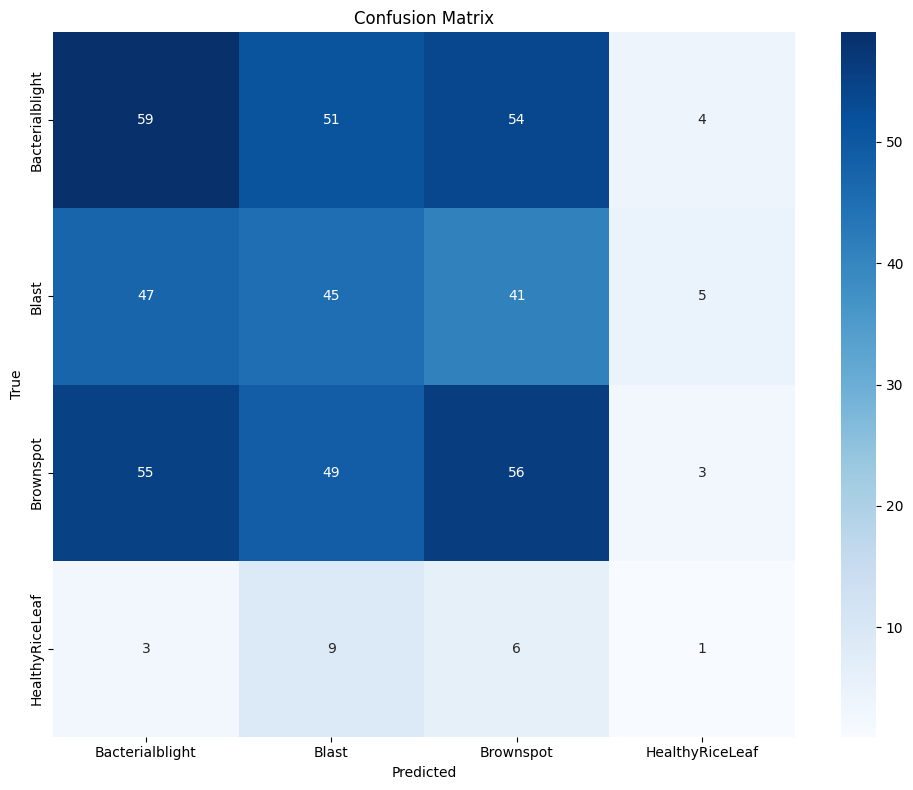

Accuracy for class 'Bacterialblight': 0.3512
Accuracy for class 'Blast': 0.3261
Accuracy for class 'Brownspot': 0.3436
Accuracy for class 'HealthyRiceLeaf': 0.0526


In [34]:
# Create a confusion matrix to see class-specific performance
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
all_labels = []

# Collect batches from test dataset and get true labels
for images, labels in test_ds:
    all_labels.append(labels.numpy())

# Convert to numpy arrays if there's data
if all_labels:
    try:
        # Get true labels
        true_classes = np.concatenate(all_labels)
        
        # Make predictions directly on the dataset to avoid memory issues
        predictions = resumed_model.predict(test_ds)
        pred_classes = np.argmax(predictions, axis=1)
        
        # Verify the shapes match
        print(f"True classes shape: {true_classes.shape}, Predicted classes shape: {pred_classes.shape}")
        
        # Make sure pred_classes doesn't have values beyond the number of classes
        n_classes_actual = len(class_names)
        print(f"Number of classes: {n_classes_actual}")
        print(f"Max predicted class index: {np.max(pred_classes)}")
        
        # Clip any out of bound predictions (shouldn't happen, but just in case)
        pred_classes = np.clip(pred_classes, 0, n_classes_actual - 1)
        
        # Create confusion matrix
        cm = confusion_matrix(true_classes, pred_classes)
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()
        
        # Calculate per-class accuracy
        class_accuracy = cm.diagonal() / cm.sum(axis=1)
        for i, acc in enumerate(class_accuracy):
            print(f"Accuracy for class '{class_names[i]}': {acc:.4f}")
    except Exception as e:
        print(f"Error generating confusion matrix: {e}")
        
        # Alternative approach - just show overall test accuracy
        print("Falling back to simple evaluation...")
        test_results = resumed_model.evaluate(test_ds, verbose=1)
        print(f"Test accuracy: {test_results[1]:.4f}")
else:
    print("No test data available")

# Recommendations for Improving Model Performance

Based on the training results (86.91% train accuracy vs 65.44% validation accuracy), here are recommendations to improve your model:

## 1. Address Overfitting
- **Add more data augmentation**: Try more transforms like zoom, contrast adjustment, and brightness
- **Increase regularization**: Try higher dropout rates (0.5-0.6) or add L2 regularization
- **Simplify model**: Reduce network complexity if still overfitting

## 2. Try Learning Rate Adjustments
- **Learning rate finder**: Try a wider range of learning rates with a warmup
- **Cyclical learning rates**: Can help escape local minima

## 3. Dataset Improvements
- **Class balancing**: Check if any classes have much fewer samples
- **Better preprocessing**: Try different normalization approaches
- **Data cleaning**: Verify if any mislabeled samples exist

## 4. Architecture Improvements
- **Transfer learning**: Try a pretrained model like MobileNetV2, ResNet or EfficientNet
- **Feature engineering**: Add domain-specific image processing for plant diseases

Rather than just running for more epochs, these changes will likely improve your model more effectively.

In [35]:
# Example code for transfer learning approach (better than just training longer)
def build_transfer_learning_model():
    # Clear previous model from memory
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Use a pre-trained model as base
    # MobileNetV2 is a good balance of accuracy and efficiency
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,  # Don't include the classification layer
        weights='imagenet'  # Use pre-trained weights from ImageNet
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # More effective data augmentation for transfer learning
    # Remove RandomContrast which doesn't work with mixed precision
    transfer_augmentation = tf.keras.Sequential([
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),  # Add zoom for more variety
        # RandomContrast removed because it doesn't support float16
    ])
    
    # Create new model with the pre-trained base
    model = tf.keras.Sequential([
        # Pre-processing 
        resize_and_rescale,
        
        # Data augmentation during training only
        tf.keras.layers.Lambda(lambda x: transfer_augmentation(x, training=True)),
        
        # Base pre-trained model
        base_model,
        
        # Add custom classification layers
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),  # Add batch norm for stability
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_classes, activation='softmax')
    ])
    
    # Build the model explicitly with input shape
    model.build(input_shape=(None,) + input_shape)  # None for batch dimension
    
    # Compile with appropriate learning rate for transfer learning
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    
    return model

print("Building transfer learning model...")
transfer_model = build_transfer_learning_model()
transfer_model.summary()  # This will now work because the model is built

print("Training transfer learning model...")
# Train the transfer learning model
transfer_history = transfer_model.fit(
    train_ds,
    epochs=15,
    verbose=1,
    validation_data=val_ds,
    callbacks=callbacks
)

# Save the transfer learning model
transfer_model.save("rice_disease_transfer_model.h5")
print("Transfer learning model saved as 'rice_disease_transfer_model.h5'")

Building transfer learning model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                  

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://d193dd8d-3f39-42aa-865e-49a54f65c257/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

first image to predict
actual label: Blast
1/1 [==============================] - 0s 82ms/step
predicted label: Blast


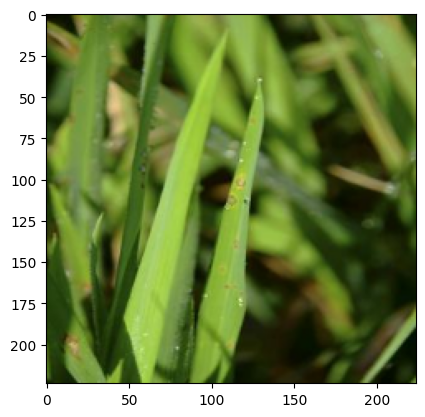

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


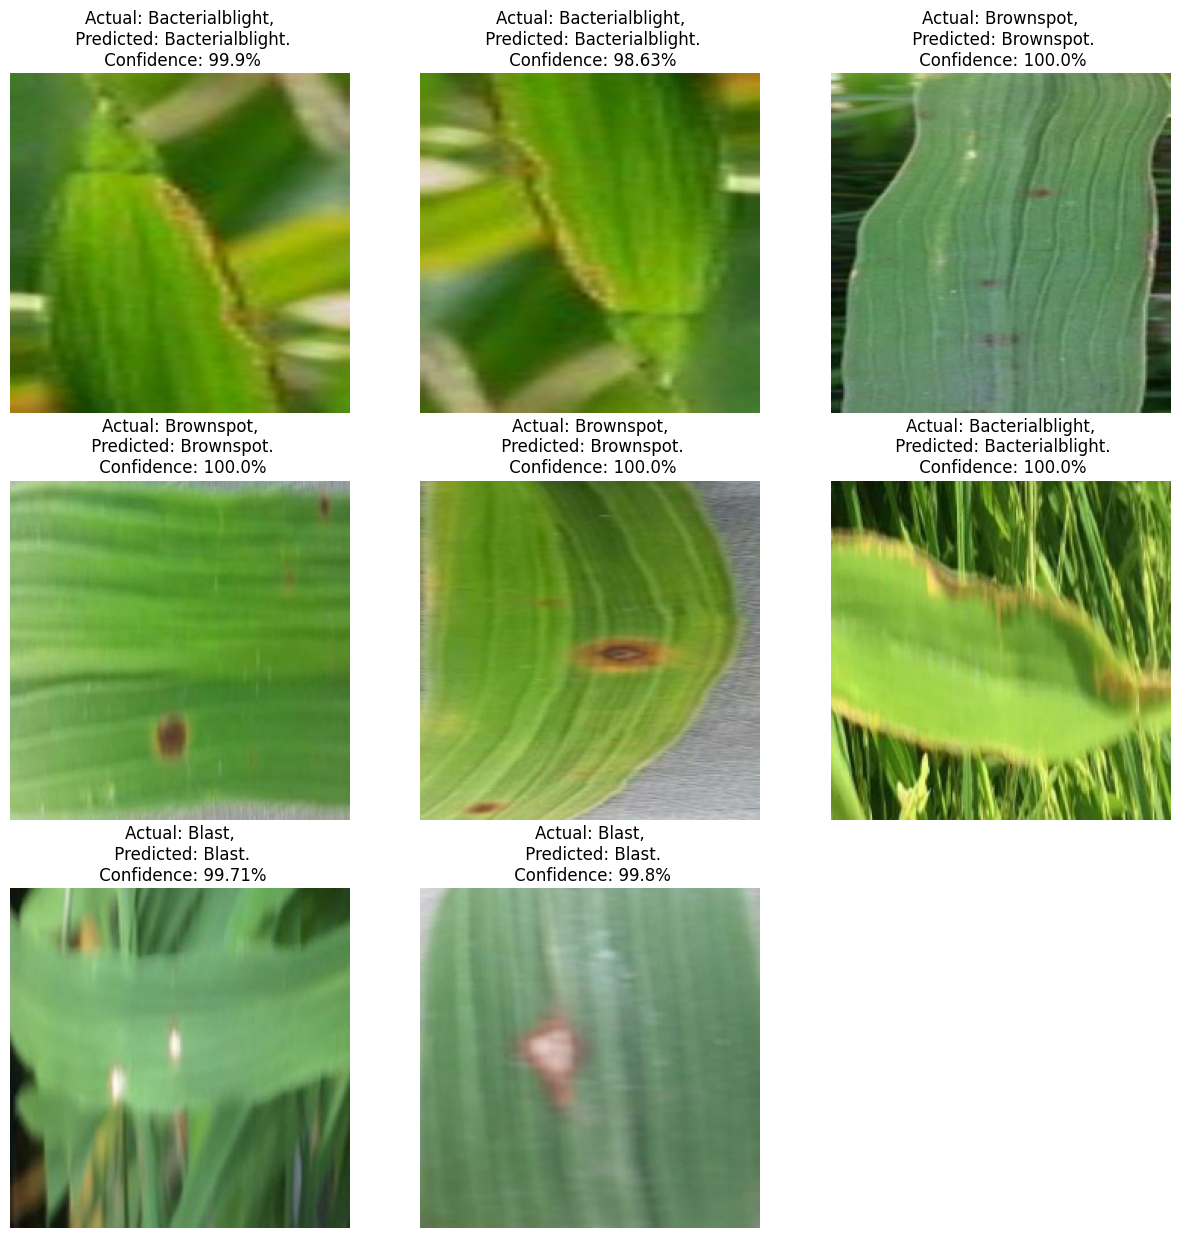

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    # Get the actual batch size
    batch_size = images.shape[0]
    grid_size = min(9, batch_size)  # Display at most 9 images
    
    for i in range(grid_size):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [43]:
model.save("saved.h5")